In [69]:
import numpy as np
import pandas as pd
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn import svm
import hdbscan
from sklearn.preprocessing import LabelEncoder,normalize,StandardScaler
from sklearn.decomposition import PCA
import xgboost as xgb
from xgboost import XGBClassifier

In [70]:
train = pd.read_csv('../../../../datasets/Project4/workingfiles/train.csv')

## Data Pre-Processing

In [71]:
cols = [i for i in train.columns]
# deal with NaNs
for i in train.columns[train.isnull().sum()>0]: # for all the columns with nans
    mean_avg_temp = train.loc[train[i].isnull()==True,'Tavg'].mean() # what is the mean Tavg
    mean_i_val = train.loc[train.Tavg==mean_avg_temp,i].mean() # what is i val for that Tavg
    train.loc[train[i].isnull()==True,'to_fill'] = mean_i_val
    train[i] = train[i].fillna(train.to_fill)
    train.drop('to_fill',axis=1,inplace=True)

train.drop('min_Wnv_species_today', axis=1, inplace=True)

In [72]:
# Drop unneeded date columns
dates = ['_date-'+str(i) for i in range(1,7)]
for i,v in enumerate(cols):
    try:
        if v in dates: # drops out the repeated date column
            train.drop(v,axis=1,inplace=True)
    except:
        pass
    try:
        if 'Date_date-' in v:
            train.drop(v,axis=1,inplace=True)
    except:
        pass

In [73]:
# Label encode the trap names and mosquito names
le = LabelEncoder()
le.fit(train.Species)
train['mosquito'] = le.transform(train.Species)
le.fit(train.Trap)
train['trap_e'] = le.transform(train.Trap)

In [74]:
# Build list of weather categories that need to be scaled (categorical columns are already dummies)

weather_cats = train.columns[300:333].tolist()

new_cats = []
for c in range(1,7):
    for w in weather_cats:
        c_string = str(c)
        cat = str(w)+'_date-'+c_string
        new_cats.append(cat)
        
weather_cats = weather_cats + new_cats

scale_exclude = ['Date', 'mosquito', 'Species', 'Trap', 'trap_e','Address', 'Block', 'Street', 
               'AddressNumberAndStreet', 'AddressAccuracy','WnvPresent', 'Coordinates', 'Weather_Station',
                'Trap_Mosquitos_today','Trap_Species_today','min_Wnv_species_today','Epoch',
                'Latitude','Longitude', 'Trap_Mosquitos_today', 'Trap_Species_today', 'NumMosquitos']

for c in weather_cats:
    scale_exclude.append(c)

scale_cols = [x for x in train.columns if x not in scale_exclude]

In [76]:
# Drop any remaining NaNs
train.dropna(inplace=True)

In [77]:
# Scaling all non-categorical numerical values using standard scaler

std_scale = StandardScaler()
train[scale_cols] = std_scale.fit_transform(train[scale_cols])

## Model Sequence:
Through exploratory modeling, we have found that the best performing models (as judged by AUC on the ROC curve) included the number of mosquitos as a predictor.  However, the test dataset does not include number of mosquitos.  So we are using a two-step modeling approach:

1. Regression:  Use a regression model to predict the number of mosquitos based on other features, and then append the predictions to our dataframe.
2. Classification:  Use the appended dataframe with predicted metrics on mosquito counts to train a classification model on whether WNV will be found in a given trap on a given day.

This will provide us the ability to perform the same steps on the test dataset, and hopefully get the best possible output.

### Regression Pre-Processing

In [78]:
# Set up list of feature columns for regression

model_exclude_cols = ['Date', 'NumMosquitos', 'Species', 'Trap', 'Address', 'Block', 'Street', 
               'AddressNumberAndStreet', 'AddressAccuracy','WnvPresent', 'Coordinates', 
                      'Weather_Station', 'Trap_Mosquitos_today', 'Trap_Species_today', 'mosquito','NumMosquitos']

In [79]:
X_cols_regression = [i for i in train.columns if i not in model_exclude_cols]

In [123]:
X_cols_regression_small = ['Latitude', 'Longitude', 'Station', 'Tmax', 'Tmin','Tavg', 'DewPoint', 'WetBulb',
                           'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed']

In [122]:
len(X_cols_regression)

587

In [121]:
len(X_cols_regression)

587

In [130]:
len(X_cols_regression_small)

14

In [131]:
X_train.shape

(6826, 14)

In [132]:
X_test.shape

(3363, 14)

In [138]:
# Defining X and y for regression
X_R = train[X_cols_regression_small]
y_total = train.NumMosquitos
y_count = train.Trap_Mosquitos_today
y_species = train.Trap_Species_today

In [139]:
# Train-test-splits for the regression models
X_train, X_test, y_train_total, y_test_total = train_test_split(X_R, y_total, test_size=.33, random_state=2)
X_train, X_test, y_train_count, y_test_count = train_test_split(X_R, y_count, test_size=.33, random_state=2)
X_train, X_test, y_train_spec, y_test_spec = train_test_split(X_R, y_species, test_size=.33, random_state=2)

### Regression Models for the Number of Mosquitos

In [140]:
# Predict NumMosquitos column

lr_total = LinearRegression(normalize=False, n_jobs=-1) # Data are already scaled/standardized
lr_total.fit(X_train, y_train_total)
y_preds = lr_total.predict(X_test)
print lr_total.score(X_test, y_preds)

1.0


In [133]:
# Predict total mosquitos in a trap on a given day (rollup value)

lr_count = LinearRegression(normalize=False, n_jobs=-1) # Data are already scaled/standardized
lr_count.fit(X_train, y_train_count)
y_preds_total = lr_count.predict(X_test)
print lr_count.score(X_test, y_preds_total)

1.0


In [134]:
# Predict all given mosquitos in a trap on a given day

lr_spec = LinearRegression(normalize=False, n_jobs=-1) # Data are already scaled/standardized
lr_spec.fit(X_train, y_train_spec)
y_preds_spec = lr_spec.predict(X_test)
print lr_spec.score(X_test, y_preds_spec)

1.0


In [137]:
# Saving fit models as pickle files, to be applied to the test dataset.
joblib.dump(lr_total, '../models/linreg_total.pkl') 
joblib.dump(lr_count, '../models/linreg_count.pkl') 
joblib.dump(lr_spec, '../models/linreg_spec.pkl') 

['../models/linreg_spec.pkl']

### Classification Pre-Processing

In [88]:
# Standard Scaler on the mosquitos count and species count columns

new_scale_cols = ['Trap_Mosquitos_today', 'Trap_Species_today', 'NumMosquitos']
train[new_scale_cols] = std_scale.fit_transform(train[new_scale_cols])

In [150]:
# Set up list of feature columns for classification

model_exclude_cols_class = ['Date', 'Species', 'Trap', 'Address', 'Block', 'Street', 
               'AddressNumberAndStreet', 'AddressAccuracy','WnvPresent', 'Coordinates', 
                      'Weather_Station', 'mosquito','Tavg_date-1', 'SeaLevel_date-1', 'AvgSpeed_date-1', 
                            'Tavg_date-2', 'SeaLevel_date-2', 'AvgSpeed_date-2', 'Tavg_date-3', 'Tavg_date-6']

In [151]:
X_cols_class = [i for i in train.columns if i not in model_exclude_cols_class]

In [152]:
# Defining X and y for the classification model
X = train[X_cols_class]
y = train.WnvPresent

In [92]:
# Running PCA on the dataset, since it has a huge number of features. This will go into a separate X dataframe

pca = PCA(n_components=31,svd_solver='full') # 30 components describe 85% of variance
pca.fit(X)
X_pca = pca.transform(X)
# print pca.explained_variance_ratio_
print pca.explained_variance_ratio_.sum()


1.0


In [153]:
# Two TTSs for classification: all data and PCA'd data.  Stratifying y b/c there are very few 1s

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, stratify=y, random_state=3) 
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=.33, stratify=y, random_state=3) 

In [166]:
# Model evaluation function


def evaluate_model(m, X=X, y=y, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    model = m.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test,y_pred,labels =[0,1])
    class_report = classification_report
    print m,'\n'
    print "Accuracy Score:\t{:0.3}".format(score.round(3)),'\n\n'
    crossval = cross_val_score(m, X, y,cv=5, n_jobs=-1)
    print "Cross Val Scores:", crossval,'\n'
    print "Cross Val mean ± Std. Dev:{:0.3}".format(np.mean(crossval), ' ± ',np.std(crossval)),'\n'
    print "Predicted Totals:"
    for i,v in enumerate(np.bincount(y)):
        print "class "+str(i)+':' , v
    print "\nConfusion Matrix:"
    conmat = np.array(confusion_matrix(y_test, y_pred, labels=[1,0]))
    confusion = pd.DataFrame(conmat, index=['Actual 1', 'Actual 0'],
                         columns=['Predicted 1','Predicted 0'])
    print(confusion),'\n'
    print "Classification Report:"
    print(classification_report(y_test, y_pred, target_names=['0','1']))
    
    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(20,16))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specificity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

### Classification Models to Predict WNV

#### Logistic Regression

LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 

Accuracy Score:	0.948 


Cross Val Scores: [ 0.94556155  0.53849926  0.91899853  0.53755523  0.44918999] 

Cross Val mean ± Std. Dev:0.678 

Predicted Totals:
class 0: 9662
class 1: 527

Confusion Matrix:
          Predicted 1  Predicted 0
Actual 1           17          157
Actual 0           18         3171 

Classification Report:
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      3189
          1       0.49      0.10      0.16       174

avg / total       0.93      0.95      0.93      3363



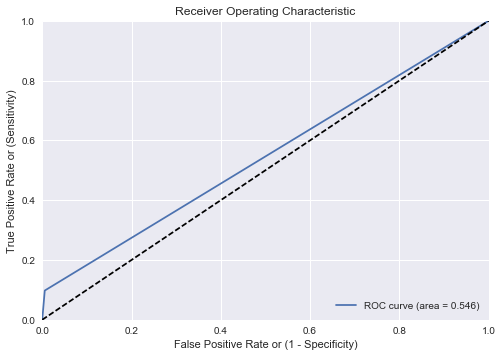

In [95]:
# All data
logreg = LogisticRegression(C=2, penalty='l1')
evaluate_model(logreg)

LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 

Accuracy Score:	0.949 


Cross Val Scores: [ 0.94801373  0.93133889  0.94894453  0.88954345  0.80559647] 

Cross Val mean ± Std. Dev:0.905 

Predicted Totals:
class 0: 9662
class 1: 527

Confusion Matrix:
          Predicted 1  Predicted 0
Actual 1            1          173
Actual 0            0         3189 

Classification Report:
             precision    recall  f1-score   support

          0       0.95      1.00      0.97      3189
          1       1.00      0.01      0.01       174

avg / total       0.95      0.95      0.92      3363



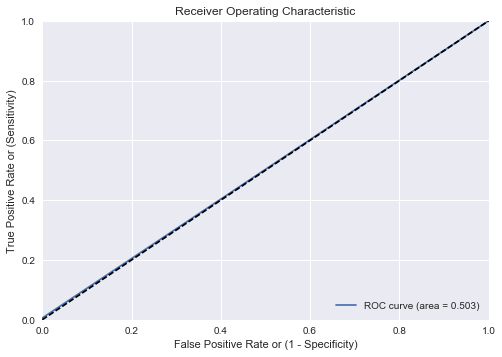

In [96]:
#  PCA
logreg_pca = LogisticRegression(C=2, penalty='l1')
evaluate_model(logreg_pca, X_pca, y, X_train_pca, X_test_pca, y_train, y_test)

#### KNN

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform') 

Accuracy Score:	0.942 


Cross Val Scores: [ 0.94801373  0.23099559  0.94845361  0.17574865  0.19489445] 

Cross Val mean ± Std. Dev:0.5 

Predicted Totals:
class 0: 9662
class 1: 527

Confusion Matrix:
          Predicted 1  Predicted 0
Actual 1           20          154
Actual 0           42         3147 

Classification Report:
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      3189
          1       0.32      0.11      0.17       174

avg / total       0.92      0.94      0.93      3363



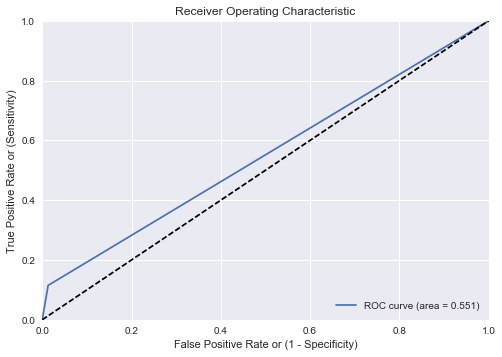

In [98]:
# All data
KNN = KNeighborsClassifier(n_neighbors=3)
evaluate_model(KNN)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform') 

Accuracy Score:	0.942 


Cross Val Scores: [ 0.94801373  0.23099559  0.94845361  0.17574865  0.19489445] 

Cross Val mean ± Std. Dev:0.5 

Predicted Totals:
class 0: 9662
class 1: 527

Confusion Matrix:
          Predicted 1  Predicted 0
Actual 1           22          152
Actual 0           42         3147 

Classification Report:
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      3189
          1       0.34      0.13      0.18       174

avg / total       0.92      0.94      0.93      3363



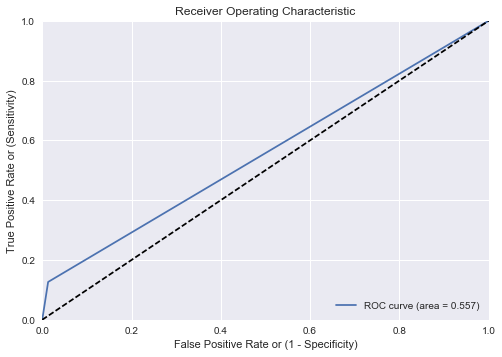

In [99]:
KNN_pca = KNeighborsClassifier(n_neighbors=3)
evaluate_model(KNN_pca, X_pca, y, X_train_pca, X_test_pca, y_train, y_test)

#### Random Forest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False) 

Accuracy Score:	0.94 


Cross Val Scores: [ 0.94703286  0.72192251  0.94845361  0.60039273  0.46980854] 

Cross Val mean ± Std. Dev:0.738 

Predicted Totals:
class 0: 9662
class 1: 527

Confusion Matrix:
          Predicted 1  Predicted 0
Actual 1           30          144
Actual 0           58         3131 

Classification Report:
             precision    recall  f1-score   support

          0       0.96      0.98      0.97      3189
          1       0.34      0.17      0.23       174

avg / total       0.92      0.94      0.93      3363



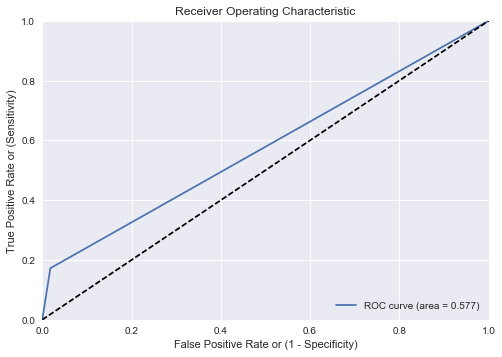

In [155]:
# All data
RF_solo = RandomForestClassifier()
evaluate_model(RF_solo)

In [156]:
joblib.dump(RF_solo, '../models/RF0427.pkl') 

['../models/RF0427.pkl']

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False) 

Accuracy Score:	0.943 


Cross Val Scores: [ 0.94556155  0.81167239  0.94845361  0.77712322  0.16445754] 

Cross Val mean ± Std. Dev:0.729 

Predicted Totals:
class 0: 9662
class 1: 527

Confusion Matrix:
          Predicted 1  Predicted 0
Actual 1           24          150
Actual 0           42         3147 

Classification Report:
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      3189
          1       0.36      0.14      0.20       174

avg / total       0.92      0.94      0.93      3363



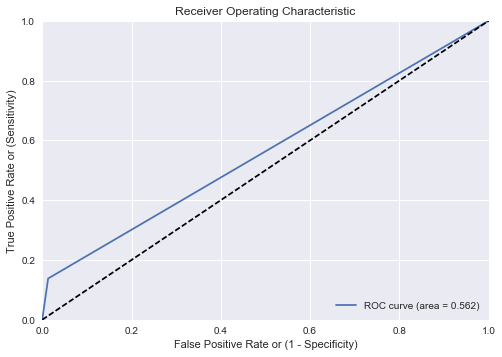

In [101]:
# PCA version
RF_solo_PCA = RandomForestClassifier()
evaluate_model(RF_solo_PCA, X_pca, y, X_train_pca, X_test_pca, y_train, y_test)

In [142]:
joblib.dump(RF_solo_PCA, '../models/RFPCA0427.pkl') 

['../models/RFPCA0427.pkl']

#### AdaBoost

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
          learning_rate=1.0, n_estimators=50, random_state=None) 

Accuracy Score:	0.931 


Cross Val Scores: [ 0.94801373  0.81559588  0.94845361  0.86156112  0.76141384] 

Cross Val mean ± Std. Dev:0.867 

Predicted Totals:
class 0: 9662
class 1: 527

Confusion Matrix:
          Predicted 1  Predicted 0
Actual 1           36          138
Actual 0           94         3095 

Classification Report:
             precision    recall  f1-score   support

          0       0.96      0.97      0.96      3189
          1       0.28      0.21      0.24

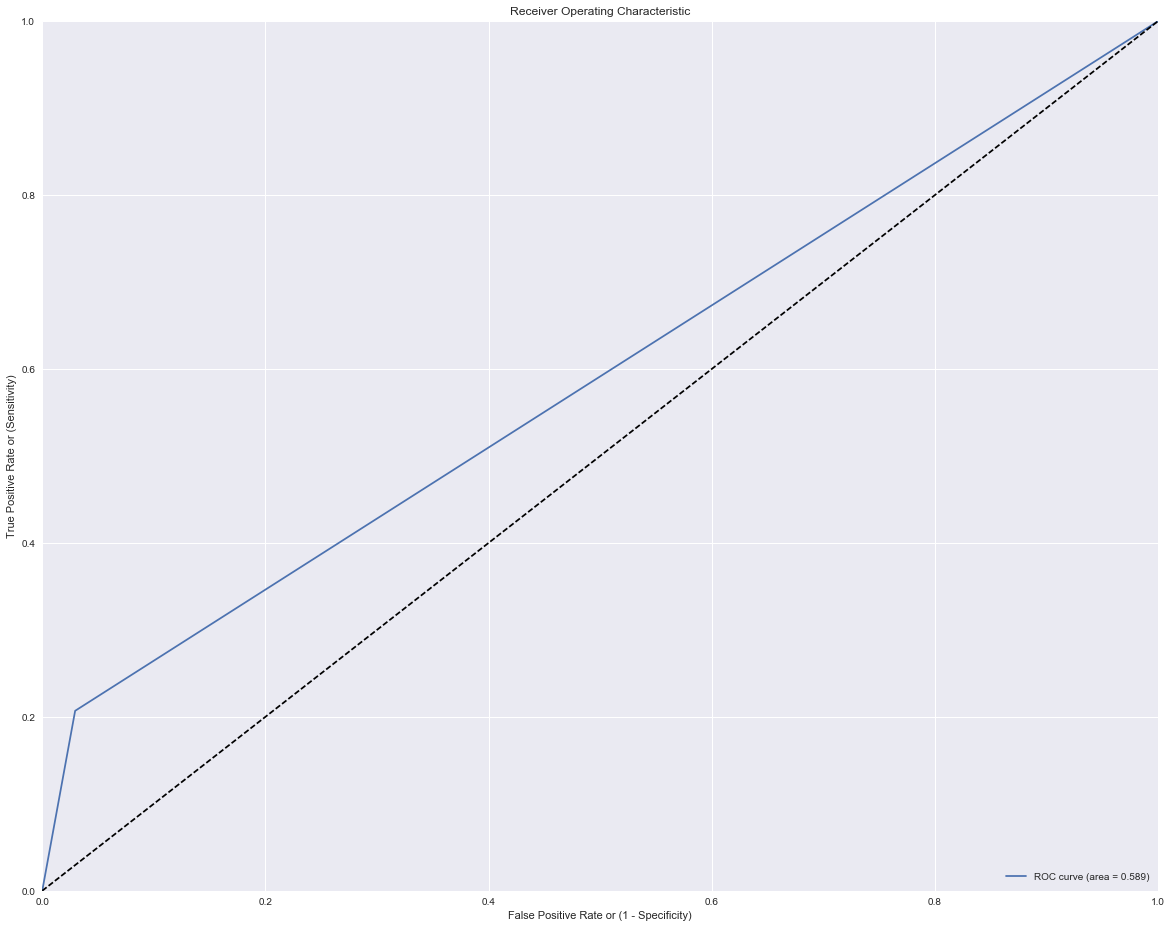

In [167]:
# All Data
rf = RandomForestClassifier()
ada = AdaBoostClassifier(base_estimator=rf)
evaluate_model(ada)

In [158]:
joblib.dump(ada, '../models/ada0427.pkl') 

['../models/ada0427.pkl']

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
          learning_rate=1.0, n_estimators=50, random_state=None) 

Accuracy Score:	0.935 


Cross Val Scores: [ 0.94801373  0.8131437   0.94845361  0.87677958  0.68041237] 

Cross Val mean ± Std. Dev:0.853 

Predicted Totals:
class 0: 9662
class 1: 527

Confusion Matrix:
          Predicted 1  Predicted 0
Actual 1           32          142
Actual 0           78         3111 

Classification Report:
             precision    recall  f1-score   support

          0       0.96      0.98      0.97      3189
          1       0.29      0.18      0.23

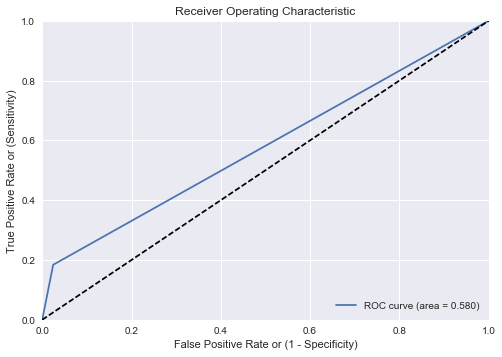

In [104]:
# PCA version
ada_pca = AdaBoostClassifier(base_estimator=rf)
evaluate_model(ada_pca, X_pca, y, X_train_pca, X_test_pca, y_train, y_test)

In [144]:
joblib.dump(ada_pca, '../models/adapca0427.pkl') 

['../models/adapca0427.pkl']

#### Gradient Boost

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False) 

Accuracy Score:	0.948 


Cross Val Scores: [ 0.94654242  0.64198136  0.94845361  0.53117329  0.16396662] 

Cross Val mean ± Std. Dev:0.646 

Predicted Totals:
class 0: 9662
class 1: 527

Confusion Matrix:
          Predicted 1  Predicted 0
Actual 1           17          157
Actual 0           19         3170 

Classification Report:
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      3189
          1       0.47      0.10      0.16       174

avg / total       0.93      0.95      0.93      3363



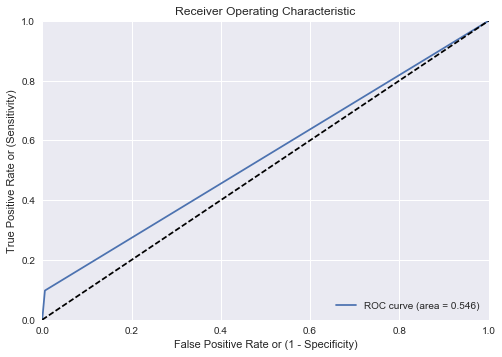

In [159]:
# All data
GB = GradientBoostingClassifier()
evaluate_model(GB)

In [160]:
joblib.dump(GB, '../models/GB0427.pkl') 

['../models/GB0427.pkl']

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False) 

Accuracy Score:	0.948 


Cross Val Scores: [ 0.94801373  0.72927906  0.94845361  0.75503191  0.16445754] 

Cross Val mean ± Std. Dev:0.709 

Predicted Totals:
class 0: 9662
class 1: 527

Confusion Matrix:
          Predicted 1  Predicted 0
Actual 1            6          168
Actual 0            7         3182 

Classification Report:
             precision    recall  f1-score   support

          0       0.95      1.00      0.97      3189
          1       0.46      0.03      0.06       174

avg / total       0.92      0.95      0.93      3363



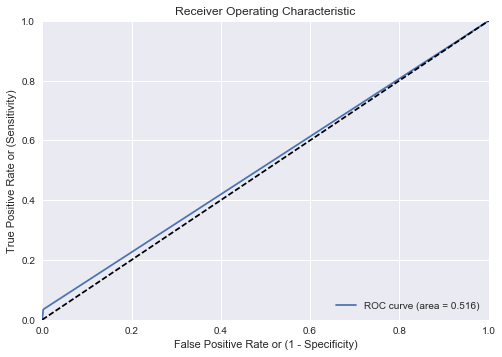

In [106]:
# PCA version
GB_pca = GradientBoostingClassifier()
evaluate_model(GB_pca, X_pca, y, X_train_pca, X_test_pca, y_train, y_test)

#### XG Boost

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1) 

Accuracy Score:	0.949 


Cross Val Scores: [ 0.94801373  0.8347229   0.94845361  0.72361316  0.1089838 ] 

Cross Val mean ± Std. Dev:0.713 

Predicted Totals:
class 0: 9662
class 1: 527

Confusion Matrix:
          Predicted 1  Predicted 0
Actual 1            7          167
Actual 0            6         3183 

Classification Report:
             precision    recall  f1-score   support

          0       0.95      1.00      0.97      3189
          1       0.54      0.04      0.07       174

avg / total       0.93      0.95      0.93      3363



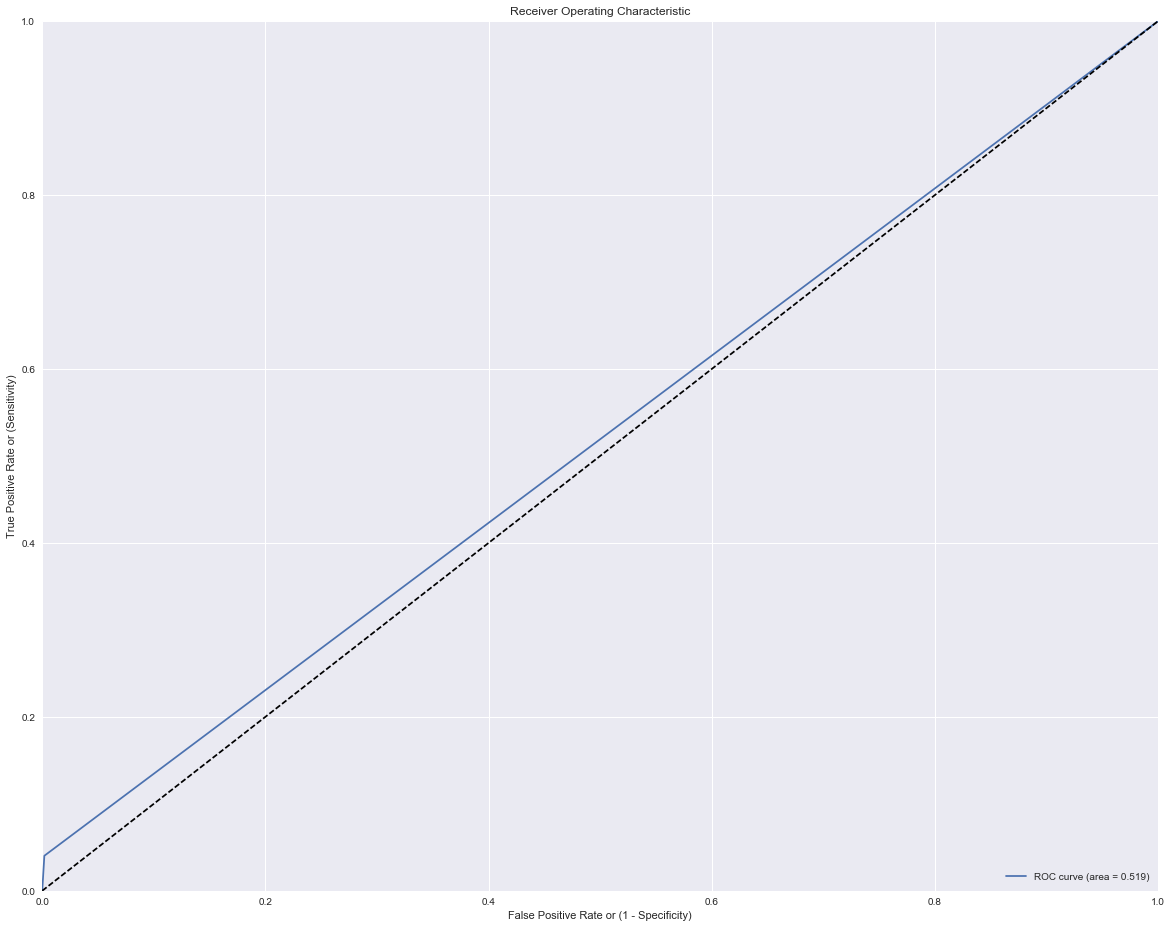

In [169]:
# All data
XGB = XGBClassifier()
evaluate_model(XGB)

In [170]:
joblib.dump(XGB, '../models/XGB0427.pkl') 

['../models/XGB0427.pkl']

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1) 

Accuracy Score:	0.949 


Cross Val Scores: [ 0.94801373  0.61942128  0.94845361  0.80756014  0.10751105] 

Cross Val mean ± Std. Dev:0.686 

Predicted Totals:
class 0: 9662
class 1: 527

Confusion Matrix:
          Predicted 1  Predicted 0
Actual 1            3          171
Actual 0            2         3187 

Classification Report:
             precision    recall  f1-score   support

          0       0.95      1.00      0.97      3189
          1       0.60      0.02      0.03       174

avg / total       0.93      0.95      0.92      3363



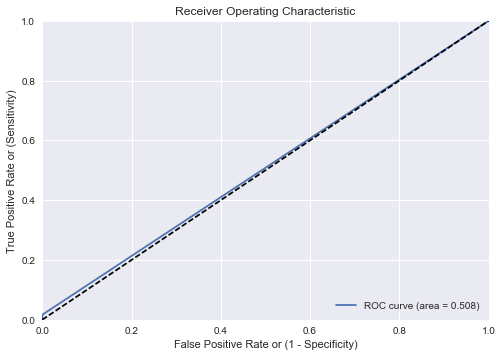

In [108]:
# PCA version
XGB_pca = XGBClassifier()
evaluate_model(XGB_pca, X_pca, y, X_train_pca, X_test_pca, y_train, y_test)

#### SVMs

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 

Accuracy Score:	0.915 


Cross Val Scores: [ 0.94801373  0.78077489  0.94894453  0.86008837  0.75503191] 

Cross Val mean ± Std. Dev:0.859 

Predicted Totals:
class 0: 9662
class 1: 527

Confusion Matrix:
          Predicted 1  Predicted 0
Actual 1           32          142
Actual 0          145         3044 

Classification Report:
             precision    recall  f1-score   support

          0       0.96      0.95      0.95      3189
          1       0.18      0.18      0.18       174

avg / total       0.92      0.91      0.92      3363



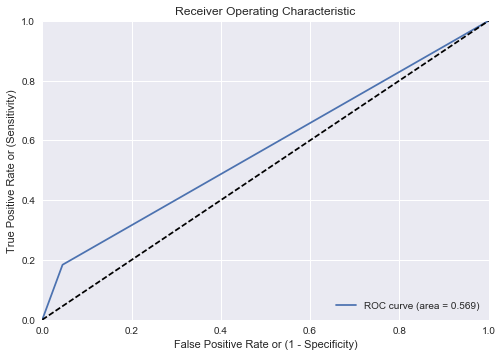

In [162]:
# All data
SVM = svm.SVC(C=10, kernel='rbf', probability=True)
evaluate_model(SVM)

In [163]:
joblib.dump(SVM, '../models/SVM0427.pkl') 

['../models/SVM0427.pkl']

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 

Accuracy Score:	0.927 


Cross Val Scores: [ 0.94801373  0.83766552  0.94845361  0.86941581  0.84830633] 

Cross Val mean ± Std. Dev:0.89 

Predicted Totals:
class 0: 9662
class 1: 527

Confusion Matrix:
          Predicted 1  Predicted 0
Actual 1           28          146
Actual 0           98         3091 

Classification Report:
             precision    recall  f1-score   support

          0       0.95      0.97      0.96      3189
          1       0.22      0.16      0.19       174

avg / total       0.92      0.93      0.92      3363



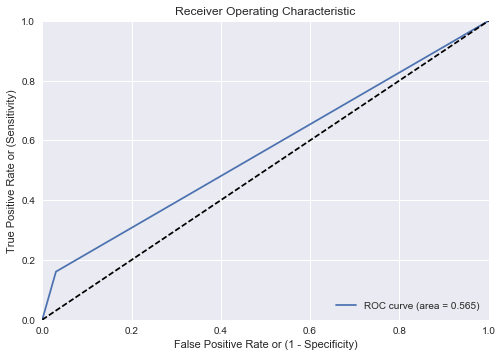

In [110]:
# PCA version
SVM_pca = svm.SVC(C=10, kernel='rbf', probability=True)
evaluate_model(SVM_pca, X_pca, y, X_train_pca, X_test_pca, y_train, y_test)

In [148]:
joblib.dump(SVM_pca, '../models/SVMpca0427.pkl') 

['../models/SVMpca0427.pkl']

#### HDBSCAN

In [111]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=50, min_samples=5)

In [112]:
# All data
clusterer.fit(X)
cluster_labels = clusterer.labels_
print(clusterer.labels_.max())

81


In [113]:
# PCA
clusterer.fit(X_pca)
cluster_labels_PCA = clusterer.labels_
print(clusterer.labels_.max())

85


#### Adding HDBSCAN Cluster Labels to Dataframes

In [114]:
X_clusters = X.copy()
X_clusters_pca = X_pca.copy()

In [115]:
X_clusters['HDBSCAN-full'] = cluster_labels
np.append(X_clusters_pca,cluster_labels_PCA)

array([ -8.58709579e+07,   6.64160689e+01,   1.45108468e+01, ...,
         1.80000000e+01,   1.80000000e+01,   1.80000000e+01])

In [116]:
## TTS for non-PCA clustered
X_clust_train, X_clust_test, y_clust_train, y_clust_test = train_test_split(X_clusters, y, test_size=.33, stratify=y, random_state=3)
X_ClPca_train, X_ClPca_test, y_ClPca_train, y_ClPca_test = train_test_split(X_clusters_pca, y, test_size = .33, stratify=y, random_state=3)

#### XGBoost with Clusters

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1) 

Accuracy Score:	0.949 


Cross Val Scores: [ 0.94801373  0.82099068  0.94845361  0.78006873  0.11487482] 

Cross Val mean ± Std. Dev:0.722 

Predicted Totals:
class 0: 9662
class 1: 527

Confusion Matrix:
          Predicted 1  Predicted 0
Actual 1            9          165
Actual 0            8         3181 

Classification Report:
             precision    recall  f1-score   support

          0       0.95      1.00      0.97      3189
          1       0.53      0.05      0.09       174

avg / total       0.93      0.95      0.93      3363



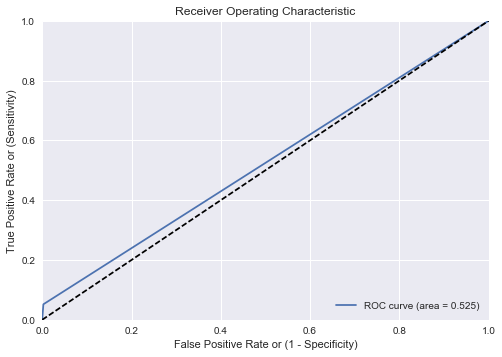

In [117]:
XGB_cluster = XGBClassifier()
evaluate_model(XGB_cluster, X_clusters, y, X_clust_train, X_clust_test, y_clust_train, y_clust_test)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1) 

Accuracy Score:	0.949 


Cross Val Scores: [ 0.94801373  0.61942128  0.94845361  0.80756014  0.10751105] 

Cross Val mean ± Std. Dev:0.686 

Predicted Totals:
class 0: 9662
class 1: 527

Confusion Matrix:
          Predicted 1  Predicted 0
Actual 1            3          171
Actual 0            2         3187 

Classification Report:
             precision    recall  f1-score   support

          0       0.95      1.00      0.97      3189
          1       0.60      0.02      0.03       174

avg / total       0.93      0.95      0.92      3363



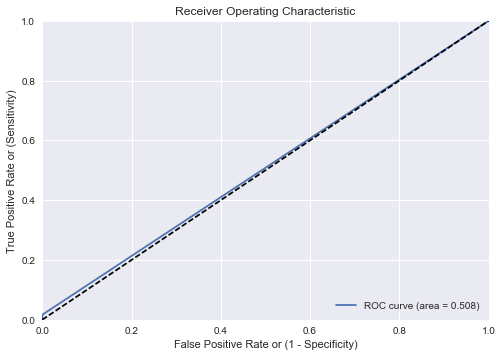

In [118]:
## XG boost with clusters, PCA
XGB_cluster_pca = XGBClassifier()
evaluate_model(XGB_cluster_pca, X_clusters_pca, y, X_ClPca_train, X_ClPca_test, y_ClPca_train, y_ClPca_test)